## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import sklearn.metrics as metrics
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

## Data Preprocessing

First, we read in the dataset.

In [2]:
#| label: dataset-preview
df = pd.read_csv("../data/wind.csv")
df.head(5)

,id,lat,long,state,farm_type,wind_speed,lcoe,capacity,capacity_factor,available_wind_power,available_energy,generated_energy,cost
0,0,25.896492,-97.460358,Texas,onshore,7.46,31,2,0.433,1.997163,17495.14630,7575.398348,4.696747e+06
1,1,26.032654,-97.738098,Texas,onshore,7.45,31,10,0.414,9.945710,87124.42376,36069.511440,2.236310e+07
2,2,26.059063,-97.208252,Texas,onshore,8.18,31,2,0.506,2.633037,23065.40088,11671.092850,7.236078e+06
3,3,26.078449,-98.073364,Texas,onshore,7.17,31,16,0.363,14.185493,124264.92160,45108.166540,2.796706e+07
4,4,26.143227,-98.311340,Texas,onshore,7.06,31,16,0.358,13.542570,118632.91080,42470.582050,2.633176e+07


Now, we must shuffle the datasets to reduce bias.

In [3]:
#| label: shuffled-dataset-preview

df = df.sample(frac=1)
df.head(5)

,id,lat,long,state,farm_type,wind_speed,lcoe,capacity,capacity_factor,available_wind_power,available_energy,generated_energy,cost
10675,10675,34.669548,-105.089355,New Mexico,onshore,8.54,33,16,0.379,23.969589,209973.60040,79579.99457,52522796.41
44621,44621,40.856514,-94.195770,Iowa,onshore,8.04,32,16,0.459,20.001157,175210.13710,80421.45291,51469729.87
42511,42511,40.648941,-95.792084,Nebraska,onshore,6.99,30,16,0.364,13.143726,115139.04170,41910.61117,25146366.70
80584,80584,42.605534,-113.541351,Idaho,onshore,6.27,44,16,0.322,9.486142,83098.59972,26757.74911,23546819.22
103886,103886,45.112122,-119.443237,Oregon,onshore,7.12,41,6,0.352,5.209046,45631.24643,16062.19874,13171002.97


Looking at each dataset, we can identify which variables we want to use for our models.

In [4]:
X = df.loc[:, ['lat','long','capacity']]
y = df.loc[:, ['generated_energy','cost']]

Now we split into training and testing sets, reserving about 80% for training and 20% for testing.

In [5]:
X_train = X[:100000]
X_test = X[100000:]
y_train = y[:100000]
y_test = y[100000:]

Models typically perform better when input values are within a certain range, like [-1, 1] for example. We scale the data points appropriately.

In [6]:
#| label: scaled-data

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[-1.34256686, -0.53171947,  0.51338678],
       [ 0.07529801,  0.38682531,  0.51338678],
       [ 0.02772857,  0.25222445,  0.51338678],
       ...,
       [-0.48304246, -1.24636626, -1.2688349 ],
       [-0.09295744, -0.45870393,  0.51338678],
       [ 0.53840359,  0.29143029,  0.51338678]])

## Training the Models

Now that the data is pre-processed accordingly, the models can be trained and fit.

In [10]:
reg = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(4,), max_iter=100000000000)
reg.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(4,), max_iter=100000000000, solver='lbfgs')

With a trained model, predictions can now be made.

In [11]:
#| label: prediction-comparisons

display = y_test.reset_index()
preds = reg.predict(X_test)
print("Predictions")
print("----------------------")
for i in range(3):
    print(f"predicted energy: {preds[i][0]:.2f}\tactual energy: {display.at[i, 'generated_energy']:.2f}\tpredicted cost: {preds[i][1]:.2f}\tactual cost: {display.at[i, 'cost']:.2f}")

Predictions
----------------------
predicted energy: 21958.97	actual energy: 14111.11	predicted cost: 23801068.69	actual cost: 13264441.96
predicted energy: 62681.37	actual energy: 56607.73	predicted cost: 40047137.50	actual cost: 37361102.91
predicted energy: 70493.43	actual energy: 67659.55	predicted cost: 45038177.19	actual cost: 47361684.06


## Testing and Analyzing the Models

This section contains metrics gathering and other figures that visualize the models and its results.

### Metrics

#### Scores and Error Values

The score being recored are the R2 score, Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

In [12]:
#| label: metrics

r2 = metrics.r2_score(y_test, preds, multioutput="raw_values")
rmse = metrics.root_mean_squared_error(y_test, preds, multioutput="raw_values")
mape = metrics.mean_absolute_percentage_error(y_test, preds, multioutput="raw_values")

print("Metric\tScore")
print("-----------------------")
print(f"r2\t{r2}\nrmse\t{rmse}\nmape\t{mape}")

Metric	Score
-----------------------
r2	[0.4101333  0.31899485]
rmse	[   24447.81951478 16382945.19553512]
mape	[0.59735542 0.53905163]


#### K-Fold Cross Validation

This cross validation splits up the dataset into 10 unique folds, which are then used to test a model. The model is then scored using the same metrics outlined above: R2, RMSE, MAPE. This ensures the scoring is rigorous, and the *entire* dataset is used.

In [15]:
#| label: k-fold-cross-validation-table

kf = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_validate(reg, X, y, cv=kf, scoring={"r2":metrics.make_scorer(score_func=metrics.r2_score),
 "rmse":metrics.make_scorer(score_func=metrics.root_mean_squared_error),
 "mape":metrics.make_scorer(score_func=metrics.mean_absolute_percentage_error)})
kf_cv_df = pd.DataFrame.from_dict(kf_cv_scores)
means = kf_cv_df.mean()
print("10-Fold Cross Validation Scores")
print("----------------------------------------------------")
print(f"R2 Average: {means.iloc[2]}")
print(f"RMSE Average: {means.iloc[3]}")
print(f"MAPE Average: {means.iloc[4]}")
kf_cv_df

10-Fold Cross Validation Scores
----------------------------------------------------
R2 Average: -0.18588620810607842
RMSE Average: 9004855.584783226
MAPE Average: 0.8463104092030183


,fit_time,score_time,test_r2,test_rmse,test_mape
0,9.437092,0.004009,0.196883,8.838669e+06,0.663618
1,8.227888,0.004006,0.320140,8.240048e+06,0.595397
2,0.247011,0.004988,-0.000188,9.863571e+06,1.096726
3,8.586757,0.015996,0.199541,8.775923e+06,0.668897
4,3.064636,0.003999,0.193190,8.891947e+06,0.742501
5,0.242979,0.003999,-0.000139,9.893215e+06,1.038674
6,1.321428,0.003990,0.190632,8.933254e+06,0.658751
7,1.388202,0.003996,0.195225,8.939861e+06,0.669760
8,0.987379,0.011011,0.198465,8.892299e+06,0.726396
9,4.561802,0.003991,-3.352610,8.779769e+06,1.602384


### Graphs

Graphs of the neural network fits on each of the input features, for each target.

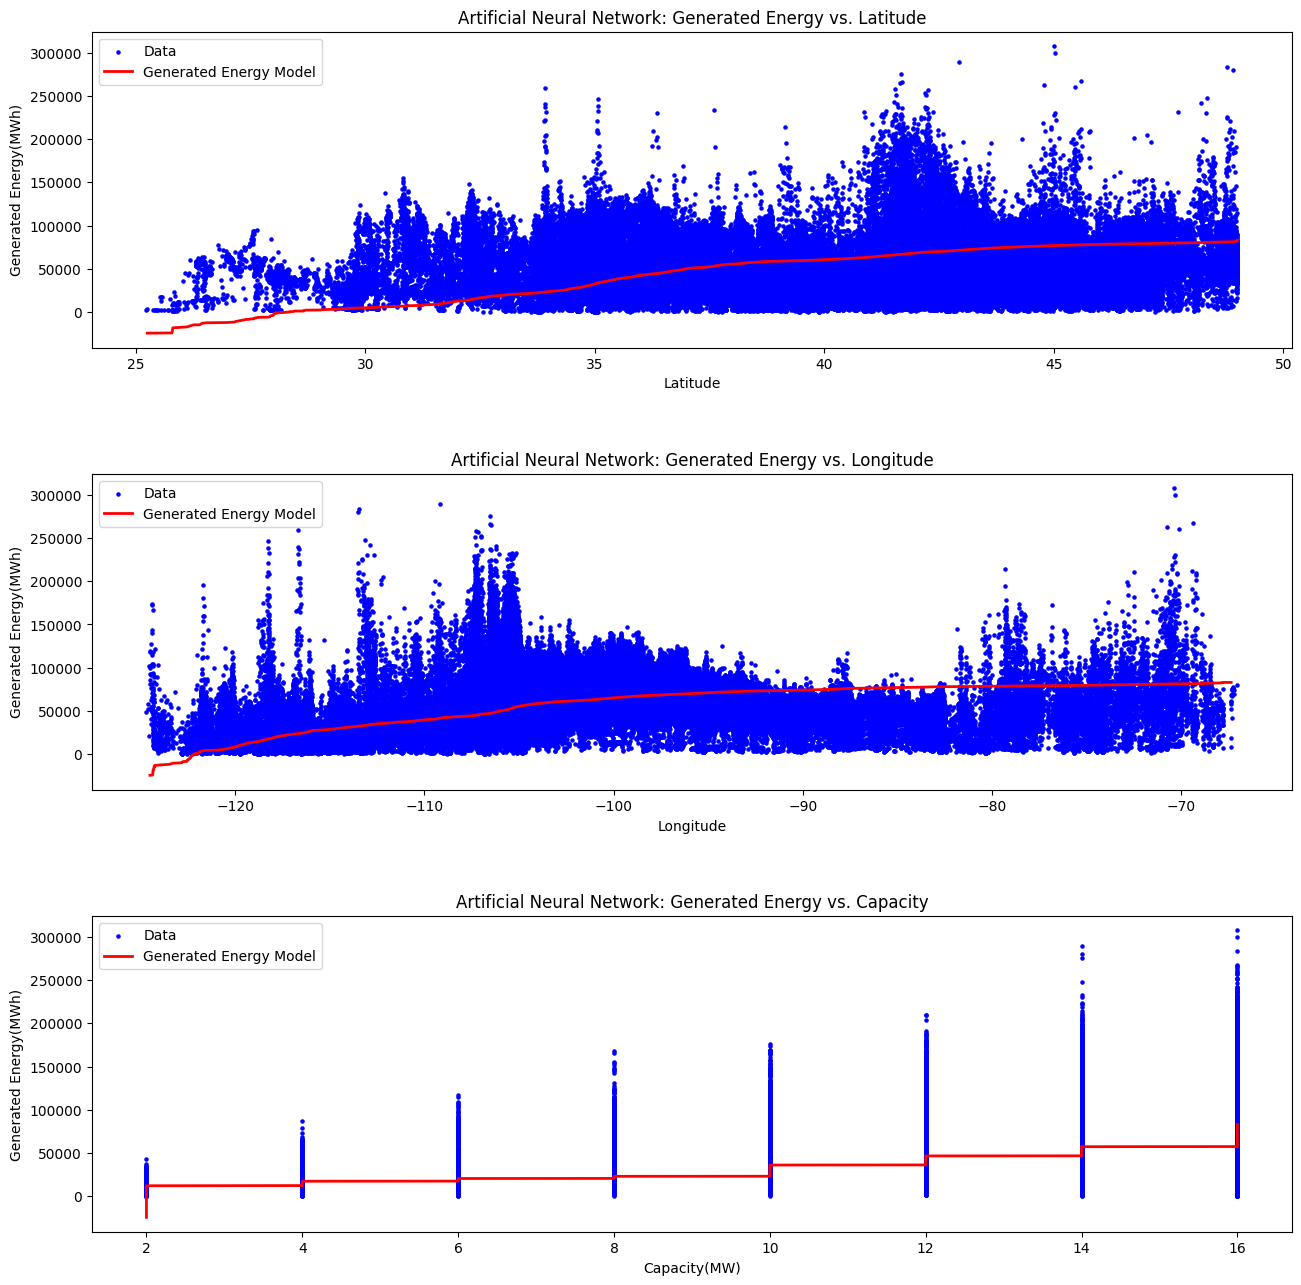

In [18]:
#| label: fig-generated-energy-vs-input-features

plot_lat_x = X[100000:].loc[:,['lat']].sort_values(by=['lat'])
plot_long_x = X[100000:].loc[:,['long']].sort_values(by=['long'])
plot_cap_x = X[100000:].loc[:,['capacity']].sort_values(by=['capacity'])
plot_energy_y = pd.DataFrame(preds).loc[:,[0]].sort_values(by=[0])

figure, axis = plt.subplots(3)

figure.set_size_inches(15,15)

axis[0].scatter(X.loc[:,["lat"]], y.loc[:,['generated_energy']], color='blue', label='Data', s=5)
axis[0].plot(plot_lat_x, plot_energy_y, color='red',lw=2, label="Generated Energy Model")
axis[0].set_xlabel("Latitude")
axis[0].set_ylabel("Generated Energy(MWh)")
axis[0].set_title("Artificial Neural Network: Generated Energy vs. Latitude")
axis[0].legend()

axis[1].scatter(X.loc[:,["long"]], y.loc[:,['generated_energy']], color='blue', label='Data', s=5)
axis[1].plot(plot_long_x, plot_energy_y, color='red',lw=2, label="Generated Energy Model")
axis[1].set_xlabel("Longitude")
axis[1].set_ylabel("Generated Energy(MWh)")
axis[1].set_title("Artificial Neural Network: Generated Energy vs. Longitude")
axis[1].legend()

axis[2].scatter(X.loc[:,["capacity"]], y.loc[:,['generated_energy']], color='blue', label='Data', s=5)
axis[2].plot(plot_cap_x, plot_energy_y, color='red',lw=2, label="Generated Energy Model")
axis[2].set_xlabel("Capacity(MW)")
axis[2].set_ylabel("Generated Energy(MWh)")
axis[2].set_title("Artificial Neural Network: Generated Energy vs. Capacity")
axis[2].legend()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=.4, 
                    hspace=.4)

plt.show()

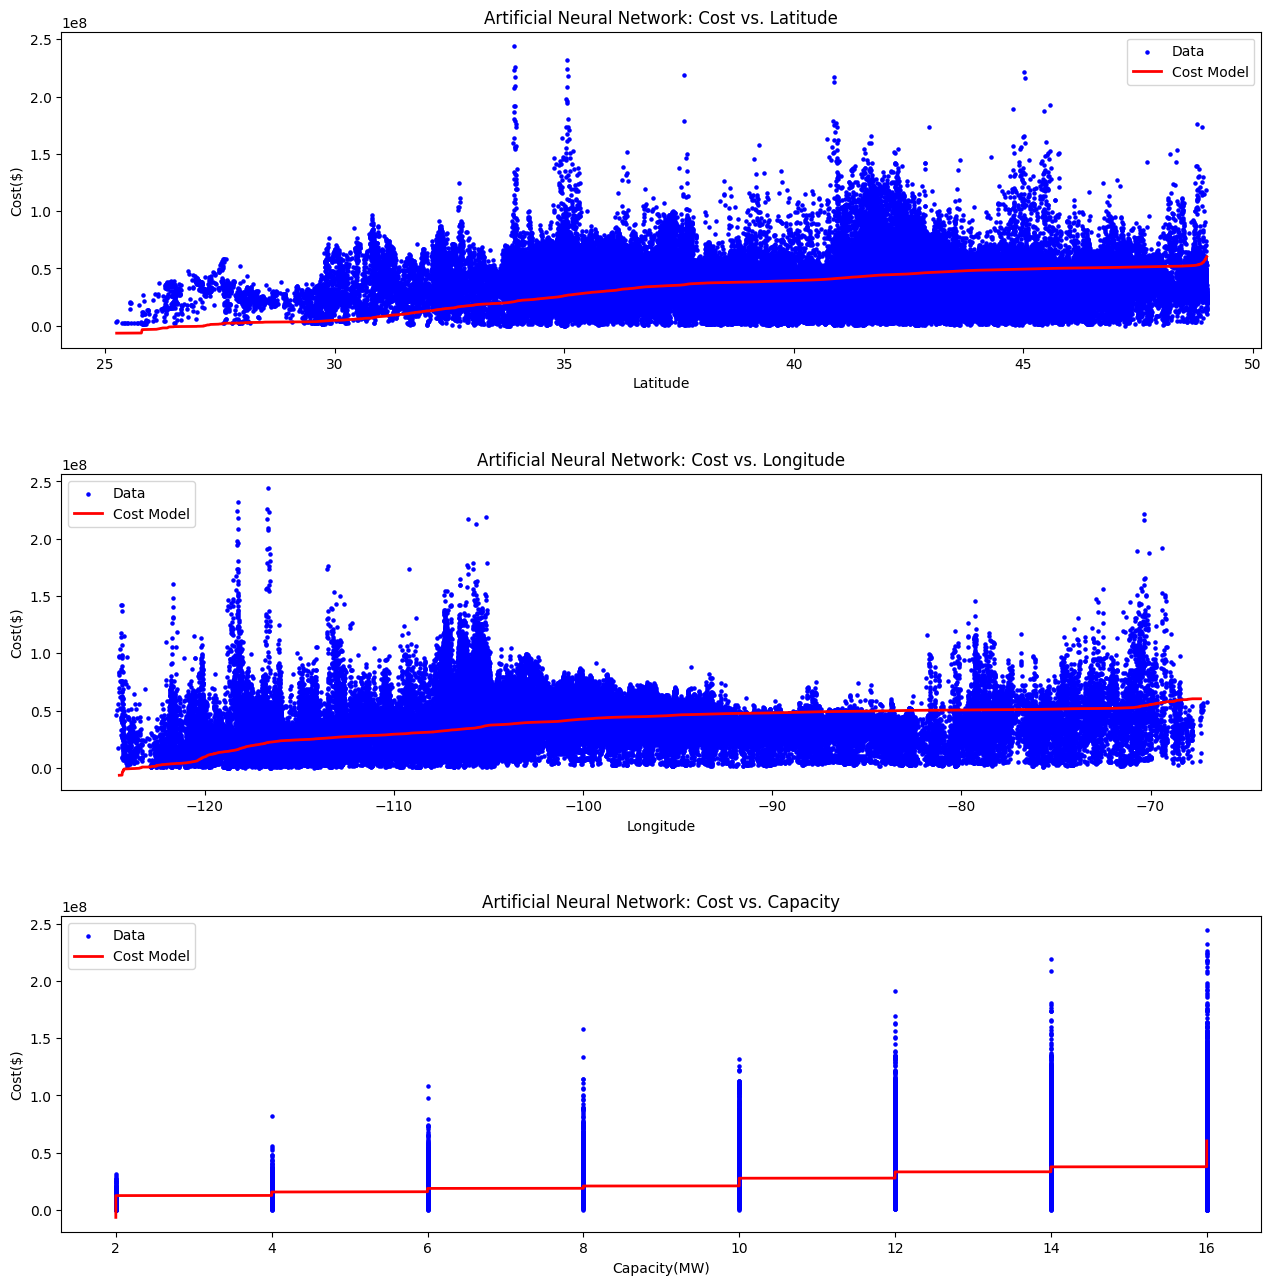

In [19]:
#| label: fig-cost-vs-input-features

plot_cost_y = pd.DataFrame(preds).loc[:,[1]].sort_values(by=[1])

figure, axis = plt.subplots(3)

figure.set_size_inches(15,15)

axis[0].scatter(X.loc[:,["lat"]], y.loc[:,['cost']], color='blue', label='Data', s=5)
axis[0].plot(plot_lat_x, plot_cost_y, color='red',lw=2, label="Cost Model")
axis[0].set_xlabel("Latitude")
axis[0].set_ylabel("Cost($)")
axis[0].set_title("Artificial Neural Network: Cost vs. Latitude")
axis[0].legend()

axis[1].scatter(X.loc[:,["long"]], y.loc[:,['cost']], color='blue', label='Data', s=5)
axis[1].plot(plot_long_x, plot_cost_y, color='red',lw=2, label="Cost Model")
axis[1].set_xlabel("Longitude")
axis[1].set_ylabel("Cost($)")
axis[1].set_title("Artificial Neural Network: Cost vs. Longitude")
axis[1].legend()

axis[2].scatter(X.loc[:,["capacity"]], y.loc[:,['cost']], color='blue', label='Data', s=5)
axis[2].plot(plot_cap_x, plot_cost_y, color='red',lw=2, label="Cost Model")
axis[2].set_xlabel("Capacity(MW)")
axis[2].set_ylabel("Cost($)")
axis[2].set_title("Artificial Neural Network: Cost vs. Capacity")
axis[2].legend()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=.4, 
                    hspace=.4)

plt.show()

A Graph that models the structure of a nueral network as a visual aid.

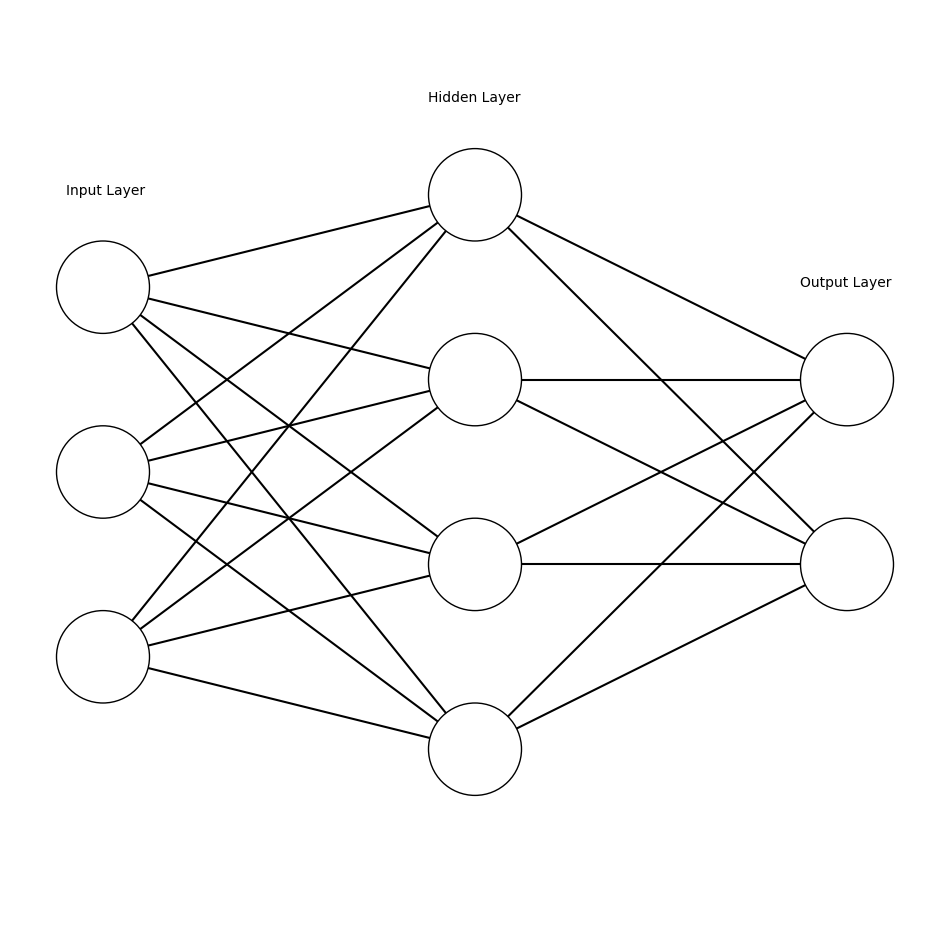

In [6]:
# Code originally comes from @craffel on GitHub: https://gist.github.com/craffel/2d727968c3aaebd10359
# Updates were made to make it compatible with Python 3
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [3, 4, 2])

plt.text(.06, .80, "Input Layer")
plt.text(.45, .90, "Hidden Layer")
plt.text(.85, .70, "Output Layer")

plt.show()